In [ ]:
import nltk
import numpy as np
import pandas as pd
import re
from operator import itemgetter
nltk.download('stopwords')
import json
import os
!git clone https://github.com/iamchiragsharma/COVID-19-Twitter-India

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Cloning into 'COVID-19-Twitter-India'...
remote: Enumerating objects: 3102, done.
remote: Total 3102 (delta 0), reused 0 (delta 0), pack-reused 3102
Receiving objects: 100% (3102/3102), 398.25 MiB | 20.11 MiB/s, done.
Checking out files: 100% (3103/3103), done.


In [ ]:
from tqdm import tqdm
import gensim
import unicodedata
import spacy
from spacy.tokenizer import Tokenizer
#!pip install preprocessor==1.0.5

In [ ]:
## STATIC VARIABLES

DATA_DIR = "/content/COVID-19-Twitter-India"
MALLET_PATH = 'mallet-2.0.8/bin/mallet'

In [ ]:
file_names_hourly = os.listdir(DATA_DIR)
file_names_hourly.remove("metadata.csv")
#Mapping Files From Hourly to Daily Basis
file_names_daily = [file_name[:-7] for file_name in file_names_hourly]
file_names_df = pd.DataFrame({'Hourly' : file_names_hourly, 'Daily': file_names_daily})[:100]

In [ ]:
file_names_df.head()

,Hourly,Daily
0,coronavirus-tweet-id-2020-04-30-11.csv,coronavirus-tweet-id-2020-04-30
1,coronavirus-tweet-id-2020-05-01-20.csv,coronavirus-tweet-id-2020-05-01
2,coronavirus-tweet-id-2020-02-09-17.csv,coronavirus-tweet-id-2020-02-09
3,coronavirus-tweet-id-2020-03-05-01.csv,coronavirus-tweet-id-2020-03-05
4,coronavirus-tweet-id-2020-04-29-01.csv,coronavirus-tweet-id-2020-04-29


In [ ]:
def corrupt_or_not(file_name):
    """Some csv files are corrupt this is a program to spot them in DATA_DIR,
    return : True if opens False for corrupt(not open)"""
    try:
        pd.read_csv(os.path.join(*[DATA_DIR,file_name]))
        return False
    except:
        return True

file_names_df['Corrupt'] = file_names_df['Hourly'].apply(corrupt_or_not)
file_names_df.groupby('Corrupt').count()

,Hourly,Daily
Corrupt,,
False,98,98
True,2,2


In [ ]:
#Removing Corrupt Files and 
#Converting the Groupby object to dict such that key is the day and values are the hourly file names
file_names_df = file_names_df[file_names_df['Corrupt'] == False]
file_daily_hourly_map = file_names_df.groupby('Daily')['Hourly'].apply(list).to_dict()

In [ ]:
 daily_full_tweets = {}

 for key,files in tqdm(file_daily_hourly_map.items()):
     hourly_df = [pd.read_csv(os.path.join(*[DATA_DIR,file_name])) for file_name in files]
     daily_df = pd.concat(hourly_df)
     daily_df = daily_df[(daily_df['full_text'] != 'No Value Mentioned') | (daily_df['full_retweet_text'] != 'No Value Mentioned')]
     daily_df.loc[daily_df['full_text'] == 'No Value Mentioned','full_text'] =  daily_df.loc[daily_df['full_text'] == 'No Value Mentioned','full_retweet_text']
     #Forcefully type casting to str because some values were just float
     daily_df['full_text'] = daily_df['full_text'].astype(str)
     daily_full_tweets[key] = " ".join(daily_df['full_text'].astype(str).values)

100%|██████████| 66/66 [00:01<00:00, 41.89it/s]


In [ ]:
daily_tweets = daily_full_tweets.values()
daily_tweets = list(daily_tweets)


In [ ]:
def remove_accent_chars(text):
    text = unicodedata.normalize('NFKD',text).encode('ascii','ignore').decode('utf-8','ignore')
    return text

def remove_special_characters(text, remove_digits=False):
    """This takes text as input and then finds whether each character is not a-z A-Z 0-9 and replaces them with nothing """
    pattern = r'[^a-zA-z\s]' if not remove_digits else r'[^0-9a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def cleaner(doc):
    return " ".join(map(str.lower,(map(str,([token.lemma_ for token in doc if not token.is_stop | token.is_space | token.is_punct | token.like_url])))))


def pipeline_2_tokenizer(daily_df):
    text_data_cleaned = list(nlp.pipe(daily_df.full_text.values.tolist(),disable=["tagger", "parser","ner"]))
    text_data_cleaned = [t for t in text_data_cleaned if t]
    text_tokens = []
    #for doc in text_data_cleaned:
     #   tokens = []
      #  for t in tokenizer(doc):
       #     if len(t.text) == 1 or len(list(set(t.text))) == 1:
        #        pass
         #   else:
          #      tokens.append(t.text)
        #text_tokens.append(tokens)
    return text_data_cleaned

nlp = spacy.load("en_core_web_sm",max_length = 2000000)
nlp.add_pipe(cleaner,name="cleaner",first=True)
nlp.add_pipe(remove_accent_chars,name='accent_char_removal',after='cleaner')
nlp.add_pipe(remove_special_characters,name='remove_special_char',after='accent_char_removal')
tokenizer = Tokenizer(nlp.vocab)
    
def single_frame(file_names):
    "Concatenates all dataframe from a day and returns dataframe after fixing the full_text column"
    hourly_df = [pd.read_csv(os.path.join(*[DATA_DIR,file_name])) for file_name in file_names]
    daily_df = pd.concat(hourly_df)
    daily_df = daily_df[(daily_df['full_text'] != 'No Value Mentioned') | (daily_df['full_retweet_text'] != 'No Value Mentioned')]
    daily_df.loc[daily_df['full_text'] == 'No Value Mentioned','full_text'] =  daily_df.loc[daily_df['full_text'] == 'No Value Mentioned','full_retweet_text']
    daily_df['full_text'] = daily_df['full_text'].astype(str)
    return daily_df

In [ ]:
file_daily_hourly_map

{'coronavirus-tweet-id-2020-01-21': ['coronavirus-tweet-id-2020-01-21-23.csv'],
 'coronavirus-tweet-id-2020-01-23': ['coronavirus-tweet-id-2020-01-23-18.csv'],
 'coronavirus-tweet-id-2020-01-24': ['coronavirus-tweet-id-2020-01-24-05.csv',
  'coronavirus-tweet-id-2020-01-24-13.csv'],
 'coronavirus-tweet-id-2020-01-25': ['coronavirus-tweet-id-2020-01-25-18.csv',
  'coronavirus-tweet-id-2020-01-25-01.csv',
  'coronavirus-tweet-id-2020-01-25-14.csv'],
 'coronavirus-tweet-id-2020-01-26': ['coronavirus-tweet-id-2020-01-26-12.csv'],
 'coronavirus-tweet-id-2020-01-31': ['coronavirus-tweet-id-2020-01-31-14.csv'],
 'coronavirus-tweet-id-2020-02-02': ['coronavirus-tweet-id-2020-02-02-08.csv'],
 'coronavirus-tweet-id-2020-02-03': ['coronavirus-tweet-id-2020-02-03-02.csv'],
 'coronavirus-tweet-id-2020-02-04': ['coronavirus-tweet-id-2020-02-04-22.csv'],
 'coronavirus-tweet-id-2020-02-05': ['coronavirus-tweet-id-2020-02-05-20.csv',
  'coronavirus-tweet-id-2020-02-05-06.csv'],
 'coronavirus-tweet-id-2

In [ ]:
#final_topics_list = {}
#def topic_words_files(daily_tweets):
#  final_retweet_text_updated = []
  
#  print(len(final_retweet_text_updated))
#  model = Top2Vec(final_retweet_text_updated,speed='deep-learn')
#  topic_words,topic_scores,topic_nums = model.get_topics(model.get_num_topics()) # 50 words(default for now) for each topic 
#  return topic_words,topic_scores,topic_nums

In [ ]:
final_df_tweets = pd.DataFrame()
final_retweet_text_updated = []
for key,file_names in tqdm(file_daily_hourly_map.items()):
  final_df_tweets = pd.concat([final_df_tweets,single_frame(file_names)],ignore_index=True)
for f in list(final_df_tweets['full_retweet_text']):
  t = type(f)
  if f!='No Value Mentioned' and t==str:
    final_retweet_text_updated.append(f)

100%|██████████| 66/66 [00:02<00:00, 23.42it/s]




> Now we have preprocessed data on which we will apply topic modelling and try to find similar documents,words to each topic using top2vec( which outperforms previous LDA AND PLSA)



In [ ]:
!pip install top2vec
from top2vec import Top2Vec 

In [ ]:
# To train the model from scratch for own list of documents otherwise download pkl file from dropbox  -
########### LINK OF TRAINED MODEL - https://www.dropbox.com/s/b71j3fgztbmepbv/model_topic_modeling.pkl?dl=0
# model = Top2Vec(final_retweet_text_updated,speed='deep-learn',workers=21) here final_retweet_text_updates is list of documents(COVID-19 tweets)
# Load trained model on COVID-19 tweets.
import pickle
fileread = open('/content/model_topic_modeling.pkl','rb')
model = pickle.load(fileread)

In [ ]:
word,word_scores = model.similar_words(['lockdown'],num_words=20)
for word,word_score in zip(word,word_scores):
  print(word,word_score)

for 0.5528
during 0.5446
to 0.5372
the 0.5004
that 0.4982
https 0.4961
in 0.4925
amp 0.4898
co 0.4893
home 0.4852
is 0.4406
now 0.4348
are 0.4339
all 0.4246
covid 0.4239
could 0.4148
so 0.4139
this 0.4077
what 0.4063
has 0.4026


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
model.get_num_topics()

924

In [ ]:
topic_words, word_scores, topic_nums = model.get_topics(model.get_num_topics())
topic_words # here topic_words are most similar 50 words to each topic where total number of topics is 924

array([['republic', 'channel', 'would', ..., 'examinations', 'abundance',
        'bhakt'],
       ['gzzp', 'yeppa', 'fdwx', ..., 'teamrealworks', 'hue', 'on'],
       ['worldhealthday', 'frontline', 'warriors', ..., 'our', 'join',
        'against'],
       ...,
       ['thala', 'valimai', 'ajith', ..., 'donation', 'donate', 'tn'],
       ['adgpi', 'rescue', 'airindiain', ..., 'hind', 'tunes', 'best'],
       ['contain', 'supplies', 'maldives', ..., 'resolve', 'effectively',
        'second']], dtype='<U15')

In [ ]:
topic_words,word_scores,topic_scores,topic_nums= model.search_topics(['lockdown','wuhan'],num_topics=11)
print('topic_words',topic_words[:5])
print('\n')
print('topic_scores',topic_scores)

topic_words [array(['flight', 'aircraft', 'arrived', 'landed', 'nationals', 'itbp',
       'airport', 'passengers', 'passenger', 'screening', 'maldives',
       'board', 'iaf', 'air', 'ccjho', 'airlifted', 'wuhan', 'maldivians',
       'crew', 'sunjaysudhir', 'airindiain', 'screened', 'lands',
       'arrival', 'special', 'carrying', 'evacuation', 'evacuated',
       'vikrammisri', 'airindia', 'cruise', 'flights', 'supplies',
       'approximately', 'second', 'dubai', 'ai', 'id', 'drsjaishankar',
       'positive', 'delhi', 'airports', 'airlines', 'ship', 'from',
       'arriving', 'aviation', 'indians', 'flying', 'transport'],
      dtype='<U15'), array(['sunjaysudhir', 'ambassadors', 'vikrammisri', 'airindia', 'housed',
       'maldivians', 'arrival', 'em', 'drsjaishankar', 'gratitude',
       'teams', 'deep', 'special', 'upon', 'flight', 'kdwlmyqft',
       'thanks', 'period', 'narendramodi', 'camaraderie', 'wuhan',
       'expeditiously', 'residing', 'quarantine', 'evacuating', 'de

In [ ]:
topic_words, word_scores, topic_nums = model.search_documents_by_keywords(keywords=["coronavirus","lockdown"],num_docs=5)
topic_words[:5]

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


array(['Uttar Pradesh to seal hotspots in 15 districts till April 30 after coronavirus COVID-19 surge\n\nhttps://t.co/DFx2awjpmY',
       'Punjab extends lockdown till June 30 with relaxations https://t.co/5OI9RPdp3y',
       'Govt extends national lockdown by two weeks #BreakingNews #COVID19 #Lockdown2 @CNBCTV18News @CNBCTV18Live',
       "LIVE: Chancellor Angela Merkel announces plans to further ease Germany's coronavirus restrictions. https://t.co/rlkBPnHgJY",
       '#lockdown Extension for further two weeks from 4th May until May17th. @MeMumbaikar8 @Bindas_Bol_ @RidlrMUM @LocalPressCo https://t.co/9YNJWx0OB4'],
      dtype=object)

In [ ]:
documents, document_scores, document_ids = model.search_documents_by_keywords(['china','virus'], num_docs=5)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print('\n')
    print(doc)
    print('##############################################')

Document: 6203, Score: 0.3246


#NoMeat_NoCoronaVirus

- China Stop Eating Meat
"Saint Rampal Ji Maharaj"
@WHO Whatch This....
https://t.co/YWK9XsNviZ
##############################################
Document: 521, Score: 0.3168


#ChinaPneumonia — 
TERRIFYING #bat-eating Chinese woman..

Back in 2003, the GLOBAL outbreak of #SARS killed more than 8,000 people. #Bat, civet cats are believed to be the origin of #virus 🦠.

#WuhanCoronavirus #coronavirus 
#China #WuhanPneumonia 🇨🇳
https://t.co/xZqGlkU44d
##############################################
Document: 5577, Score: 0.3152


Never kill animals for eating eat, they are entitled to live, not born to kill - Jagatguru Saint Rampal Ji Maharaj
Stop eating meat.
China
#NoMeat_NoCoronaVirus https://t.co/nI7ylQhcgZ
##############################################
Document: 6687, Score: 0.314


#NoMeat_NoCoronaVirus
Eating meat is sinful
China
Saint Rampal ji Maharaj https://t.co/eAwh14LWL8
##############################################
Document

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


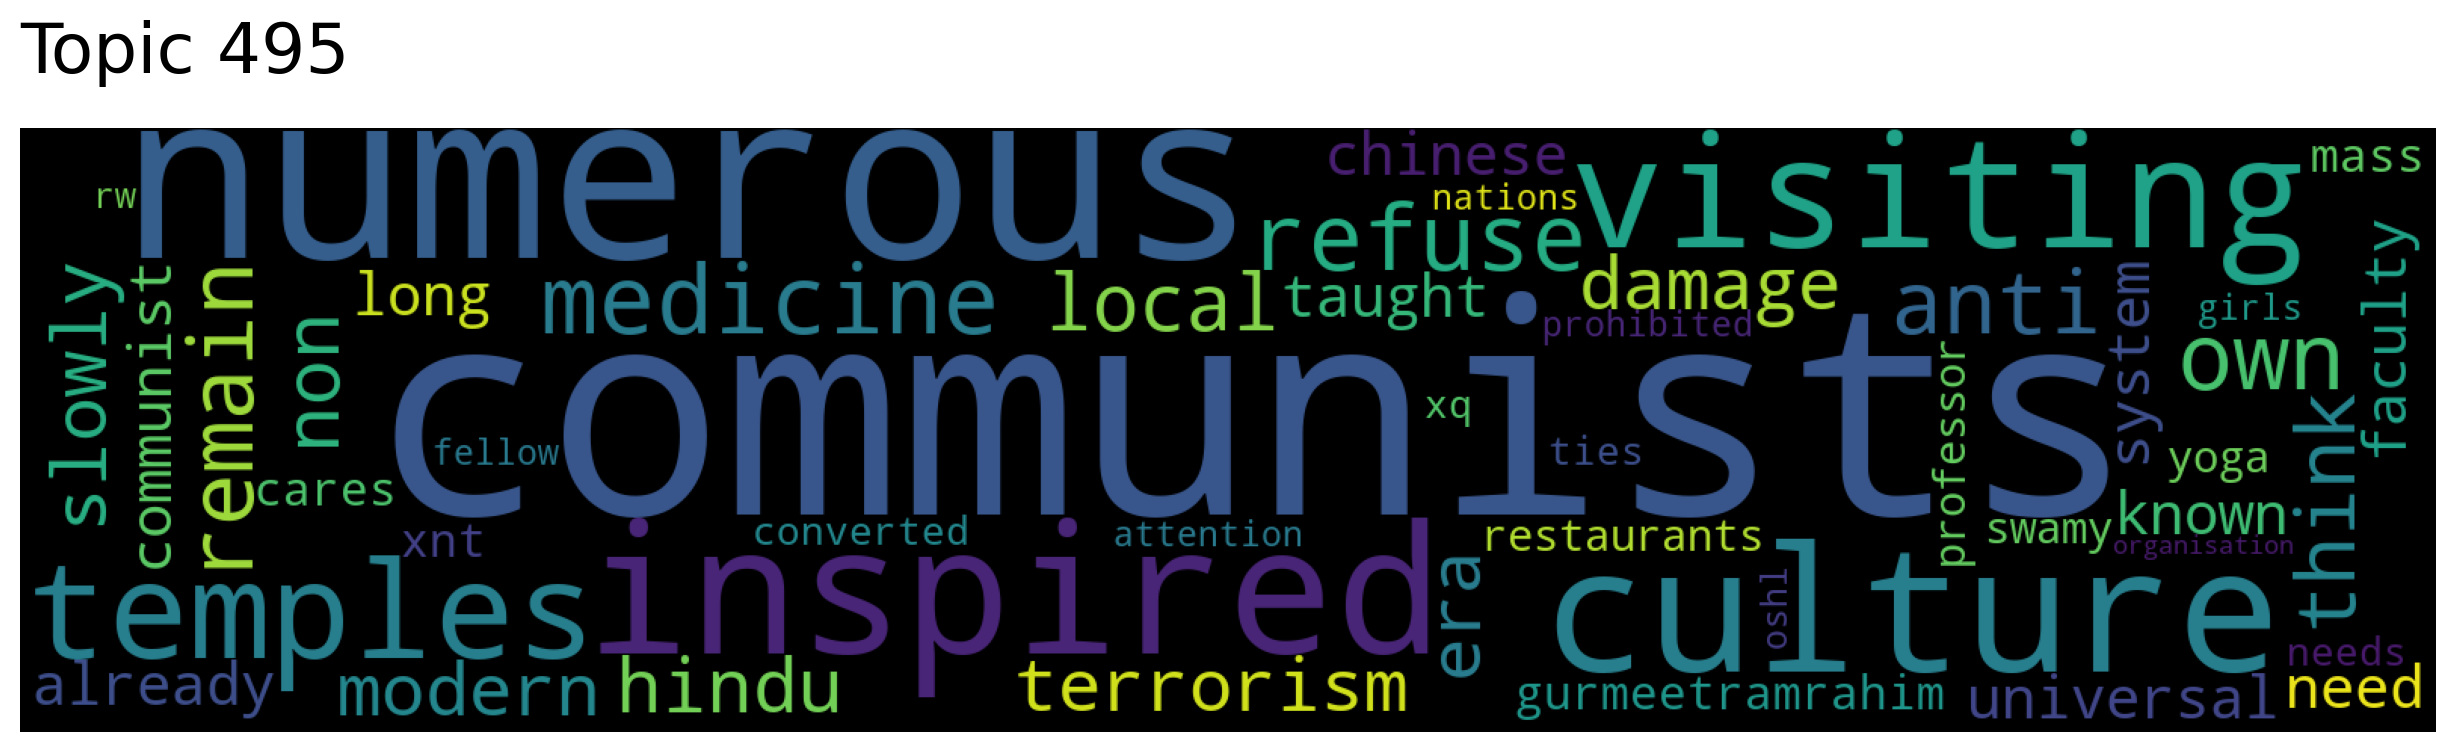

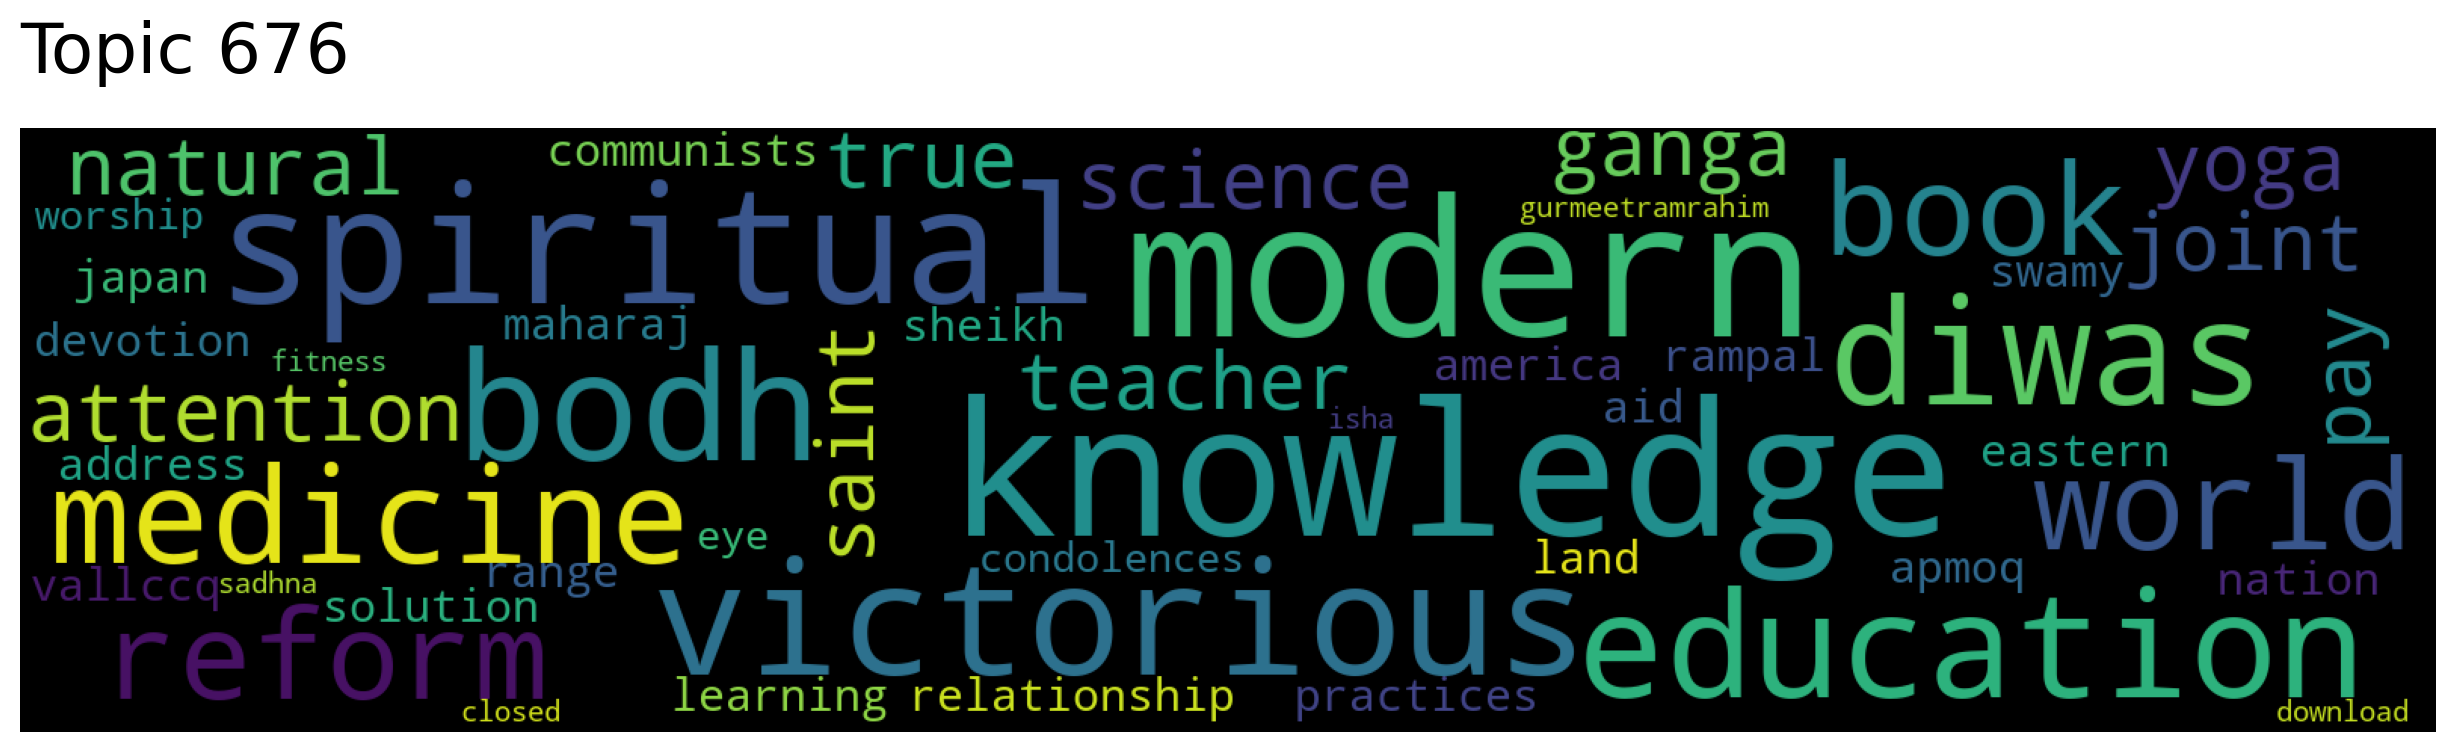

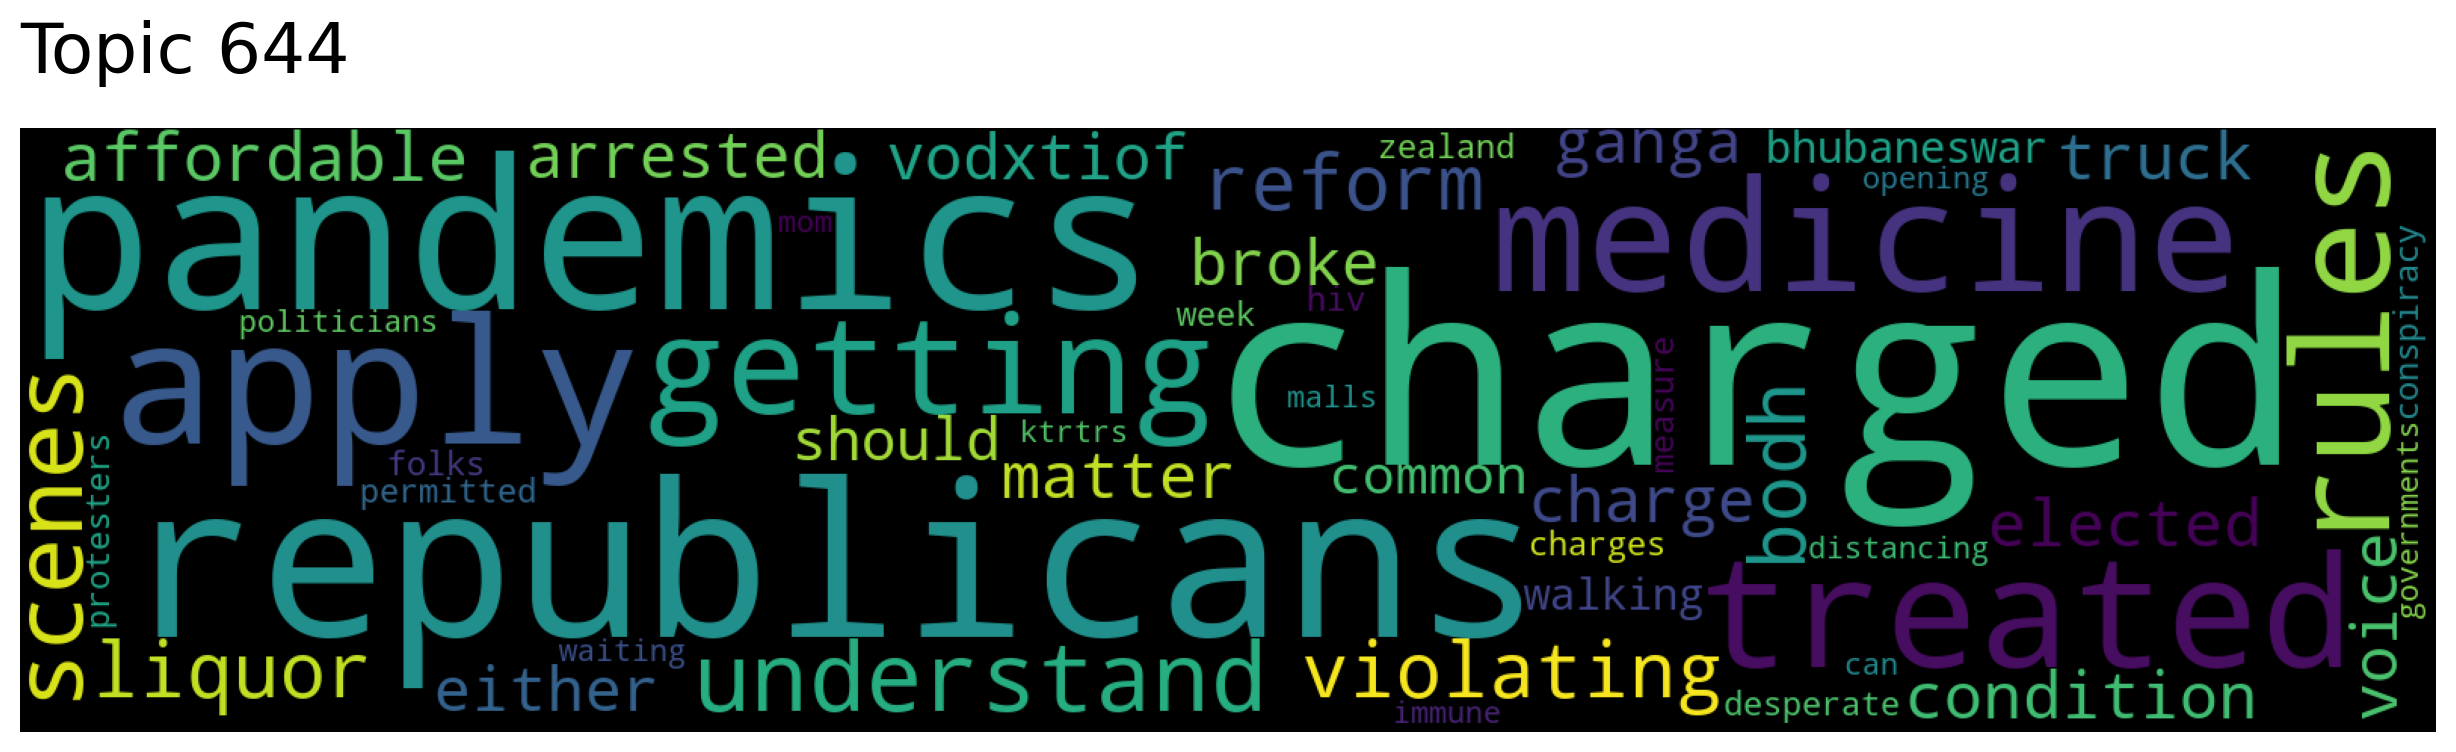

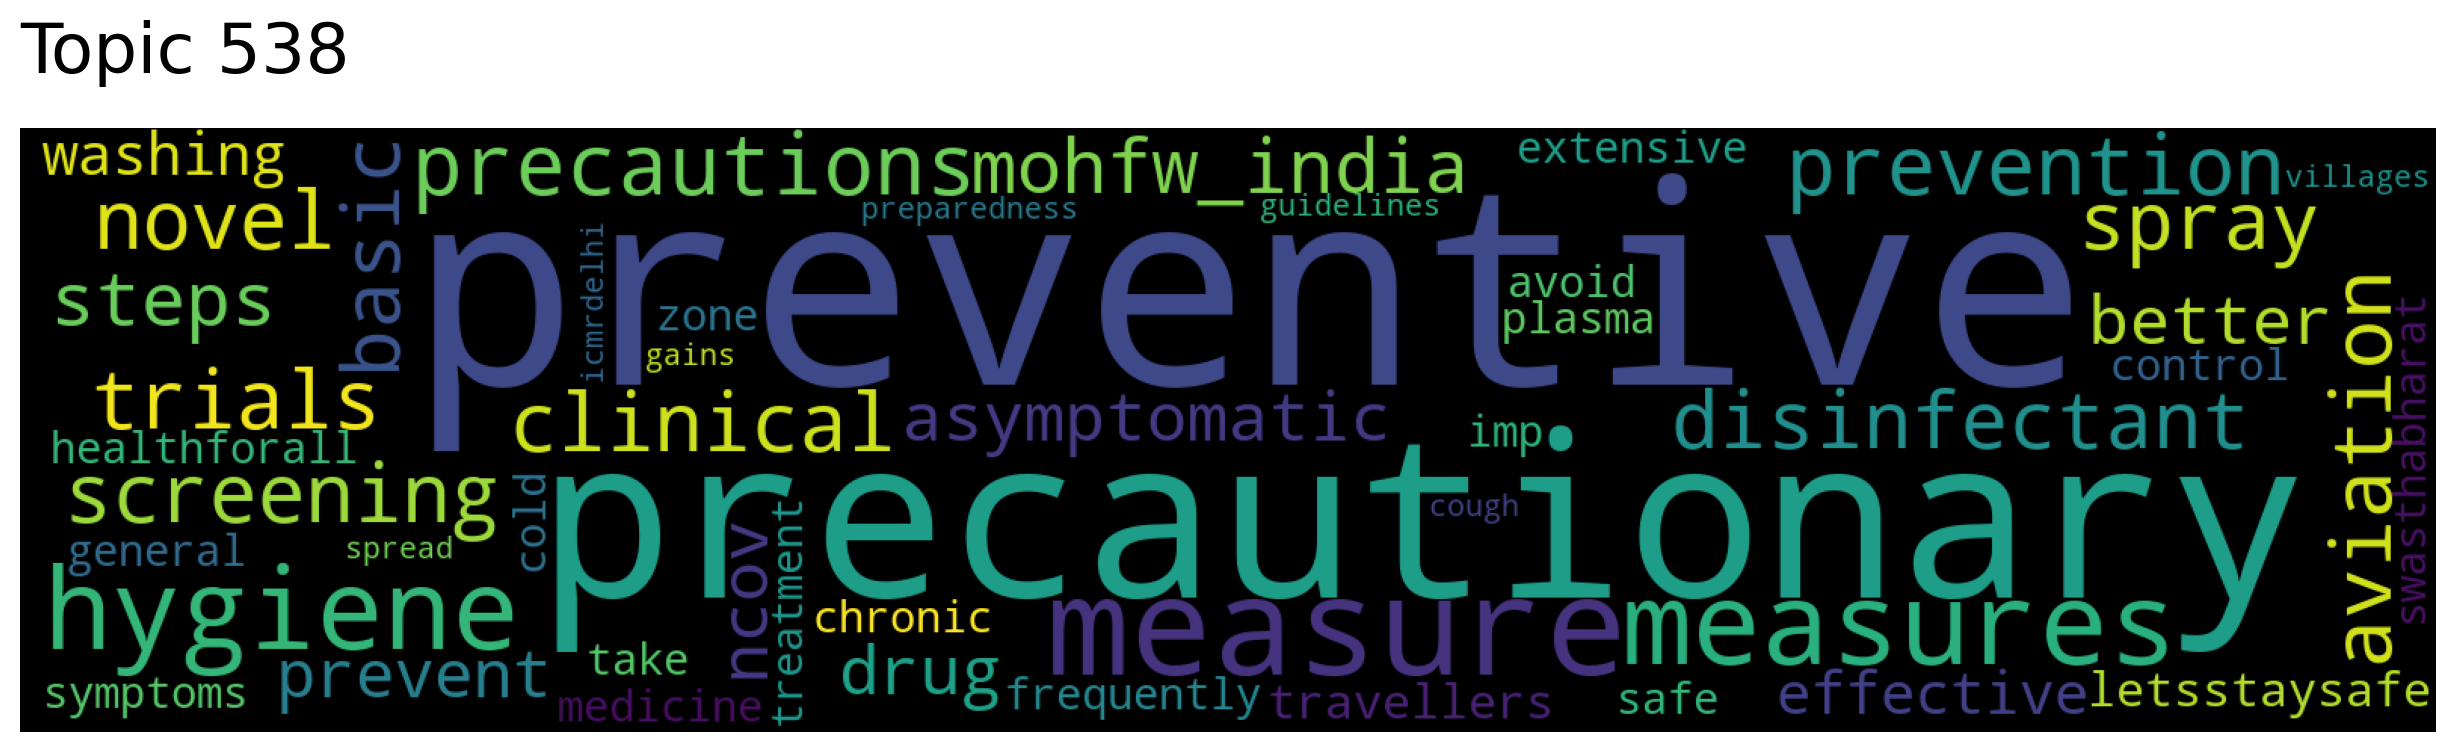

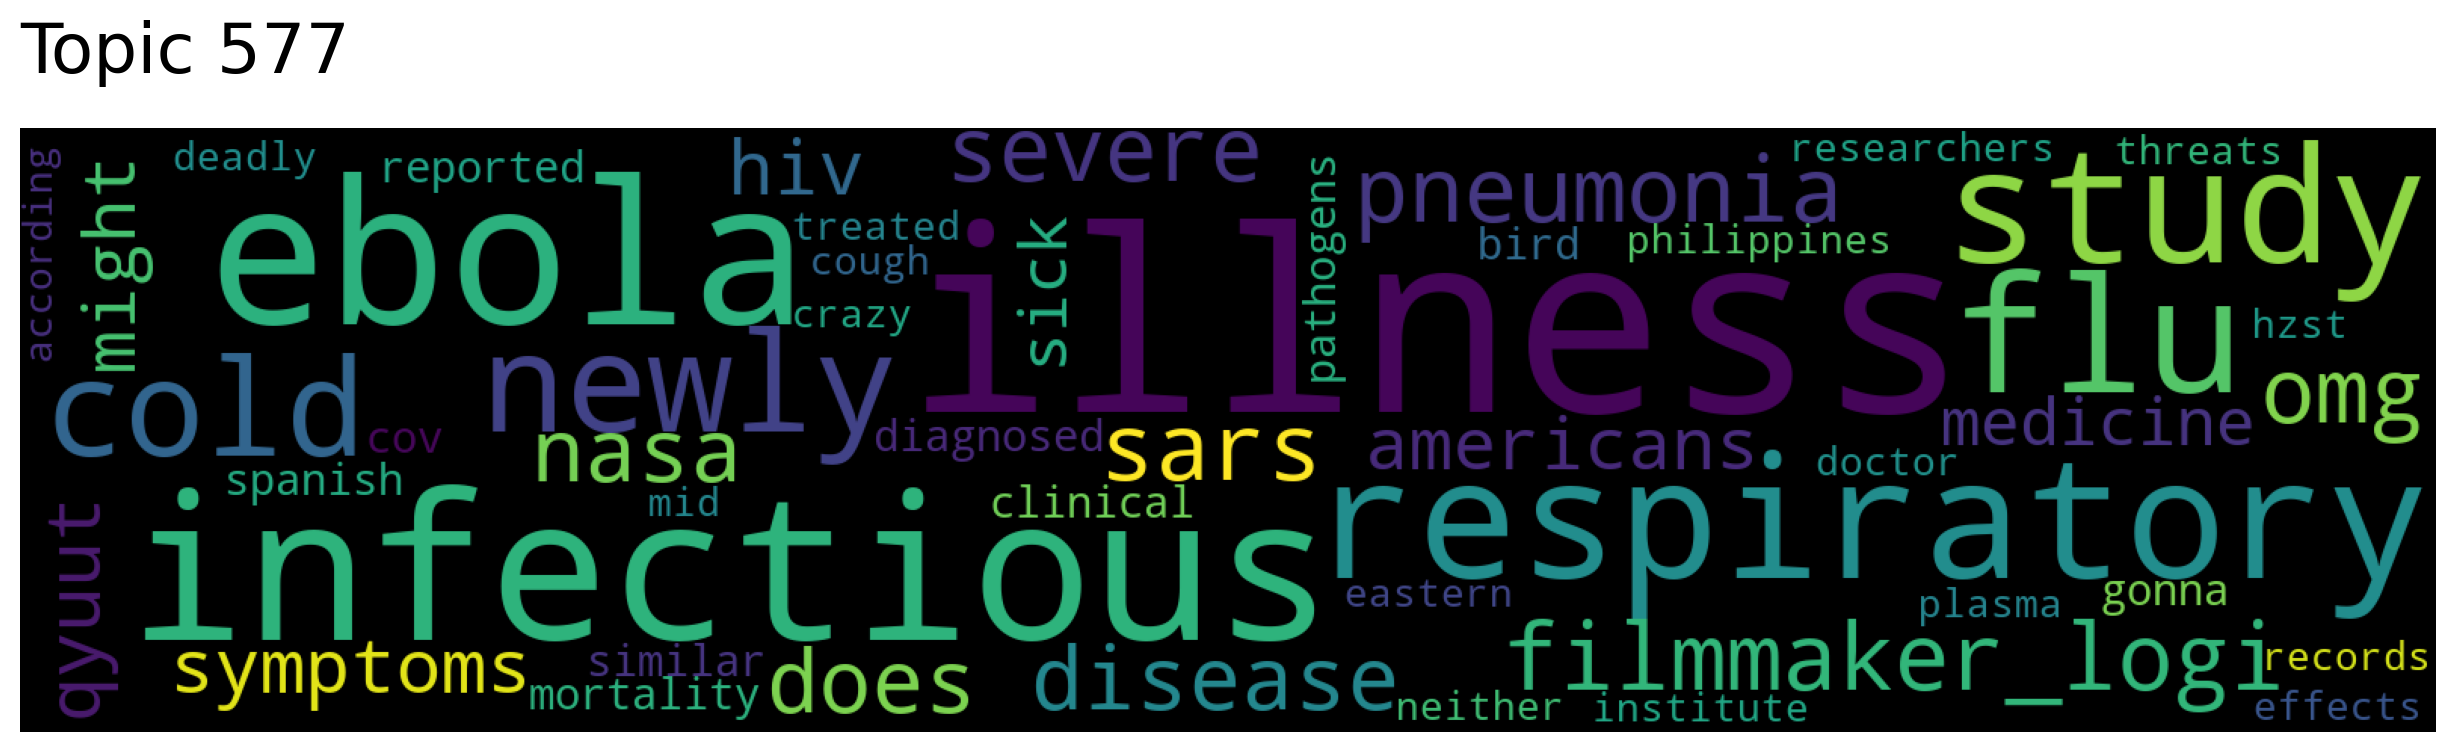

In [ ]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["medicine"], num_topics=5)
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

In [ ]:
###### TODO ##########
# Apply UMAPS for dimension reduction and visualize topics for each document along with similar words